<a href="https://colab.research.google.com/github/LittleOneNoise/SNLP_Fact_Checking/blob/main/fact_engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
#mount the drive and install wikipedia library
!pip install wikipedia
from google.colab import drive

# generic libraries
from tqdm.notebook import tqdm
import os
import json
import csv
import re
from collections import Counter
import spacy
import matplotlib.pyplot as plt

# task specific libraries
import unicodedata
import wikipedia as wiki
import urllib.request
from urllib.request import urlopen
from urllib.error import HTTPError
from bs4 import BeautifulSoup

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ***The Class of GatherData is used to collect the raw information that was provided and extract relevant information for the fact checking task!***

In [17]:
class GatherData:
    def __init__(self, file_name, save_path, dataset_type='train', categories=dict()):
        self.file_name = file_name
        self.stop_words = ['s', 'is', 'the', 'that', 'a', 'in', "of"]
        self.dataset_type = dataset_type
        self.categories = categories
        self.nlp = spacy.load('en_core_web_sm')
        self.save_path = save_path

    def collect_data(self):
        """
        Method yields each line from the given file

        :yield: each line from the given file
        """
        with open(self.file_name) as file_test:
            tsv_file = csv.reader(file_test, delimiter="\t")
            for line in tsv_file:
                yield line

    def extract_information(self):
        """
        Method extract needed information from raw data
        :return: data_dict: dictionary that includes information such as raw_sentence, clean_sentence,
        tokenized_sentence, label, category and organizations that sentences might involve
        """
        data_dict = dict()
        length_dataset = 0

        for each_data in self.collect_data():
            length_dataset += 1

        processing_bar = tqdm(iterable=self.collect_data(), desc='Data is collected and processed',
                              total=length_dataset, leave=False)

        all_sentences = list()
        for each_data in processing_bar:
            if self.dataset_type == 'train':
                each_id, each_sentence, each_label = each_data
                categories = self.extract_categories()
            else:
                categories = self.categories
                each_id, each_sentence = each_data

            clean_sentence = self.clean_sentences(each_sentence)
            splitted_sentence = self.tokenize_sentence(each_sentence, stopwords=False)
            bigram_sentence, raw_bigrams = self.extract_bigrams(splitted_sentence)
            category = self.generate_categories(categories['bigram_categories'], bigram_sentence)

            if category == 'None_cat':
                category = self.generate_categories(categories['unigram_categories'], splitted_sentence)

            organizations = self.extract_organizations(each_sentence)

            data_dict[each_id] = {
                'raw_sentence': each_sentence,
                'clean_sentence': clean_sentence,
                'tokenized_sentence': splitted_sentence,
                'category': category,
                'label': each_label if self.dataset_type == 'train' else 'None',
                'organizations_spacy': organizations
            }
            processing_bar.set_description(f'Data is collected and processed: {each_id}')

        return data_dict

    def generate_categories(self, categories, sentence):
        """
        Generate category with respect to given sentence and list of categories that were extracted from dataset
        :param categories: list of categories that were extracted from dataset (can be unigrams or bigrams)
        :param sentence: tokenized sentence with unigrams or bigrams according to the category type
        :return: category of the sentence if it exists, otherwise 'None_cat' stands for unsuccessful category matching
        """
        cat = list()
        count = 0

        for each in sentence:
            if each in categories:
                count += 1
                cat.append(each)
                if count == 1:
                    break
        if count == 1:
            return cat[0]
        else:
            return 'None_cat'

    def extract_categories(self):
        """
        Method is used to extract categories from the given tokenized sentences. It uses counter and categories were
        extracted according to the most common words in the whole dataset.
        Note: Categories are extracted according to the train dataset!
        :return: dictionary of categories which has the following structure:
        {'unigram_categories': list of unigram categories, 'bigram_categories': list of bigram_categories}
        """
        bigrams = list()
        unigrams = list()
        length_dataset = 0

        for each_data in self.collect_data():
            bigrams.extend(self.extract_bigrams(self.tokenize_sentence(each_data[1]))[0])
            unigrams.extend(self.tokenize_sentence(each_data[1]))

        categories = dict()
        bi_counter = Counter(bigrams)
        bigram_categories = [each_cat for each_cat, freq in bi_counter.most_common() if
                             freq >= 75 and each_cat != 'award nobel' and each_cat != 'prize literature' and each_cat != 'nobel prize']

        uni_counter = Counter(unigrams)
        unigram_categories = [each_cat for each_cat, freq in uni_counter.most_common() if
                              freq >= 60 and each_cat not in ['the', 'new', 'literature', 'nobel', 'prize']]
        unigram_categories.append('squad')

        tokenized_bigrams = list()

        for each in bigram_categories:
            tokenized_bigrams.extend(self.tokenize_sentence(each))

        tokbi_counter = Counter(tokenized_bigrams)
        all_tokens_cat = [each_element for each_element, each_freq in tokbi_counter.most_common()]

        categories['bigram_categories'] = bigram_categories
        uni_cats = list()

        for each_uni in unigram_categories:
            if (each_uni not in all_tokens_cat):
                uni_cats.append(each_uni)

        categories['unigram_categories'] = uni_cats

        return categories

    def tokenize_sentence(self, sentence, pattern='\W', stopwords=True):
        """
        Tokenize given sentence according to the given pattern and boolean flag
        :param sentence: given raw sentence was extracted from the dataset
        :param pattern: given pattern is used for regex matching in the given sentence
        :param stopwords: boolean flag determines whether stopwords should be discarded or not
        :return: list of tokens in the sentence that includes also stopwords if flag is False
        """
        if stopwords:
            return [word.lower() for word in re.split(pattern, sentence) if word and word not in self.stop_words]
        else:
            return [word.lower() for word in re.split(pattern, sentence) if word]

    def extract_bigrams(self, sentence):
        """
        Method extracts bigrams in order to use them for category matching in future
        :param sentence: tokenized sentence which was generated from the given raw sentence
        :return: combined_bigram_sentence: list of string bigrams, e.g., [nobel prize]
                 raw_bigram_sentence: list of two tokens make the bigram, e.g., [nobel, prize]
        """
        combined_bigram_sentence = list()
        raw_bigram_sentence = list()
        for current_idx in range(len(sentence)):
            if current_idx != len(sentence) - 1:
                current = sentence[current_idx: current_idx + 2]
                combined = current[0] + ' ' + current[1]
            combined_bigram_sentence.append(combined)
            raw_bigram_sentence.append(current)
        return combined_bigram_sentence, raw_bigram_sentence

    def clean_sentences(self, sentence):
        """
        Method was generated for exemptions where sentence can include extra information after it ends
        (e.g., Arthur C. Doyle is Scherlock Holmes' author. (author))
        :param sentence: raw sentence was extracted from the dataset
        :return: new_sentence: resulting sentence where the extra information was discarded
        (e.g., Arthur C. Doyle is Scherlock Holmes' author.)
        """
        limit_idx = ''
        new_sentence = ''
        for each_idx in range(len(sentence)):
            new_sentence += sentence[each_idx]
            if sentence[each_idx] == '.' and each_idx == len(sentence) - 1:
                break
        return new_sentence

    def extract_extra_categories(self, dict_data):
        """
        Method is used to gather other categories that could not be gathered because of the threshold conditioning
        :param dict_data: dictionary of dataset that includes all possible valuable information from raw data
        :return: extra_categories: list of categories that were mentioned above
        """
        uncat_data = dict()
        organizations = list()
        collection = list()
        for each_id, each_data in dict_data.items():
            if each_data['category'] == 'None_cat':
                uncat_data[each_id] = each_data
                organizations.extend(each_data['organizations_spacy'])
                collection.extend(each_data['tokenized_sentence'])
            uncat_collection = Counter(collection)
            organizations = [each.lower() for each in organizations]
            extra_categories = [each_token for each_token, each_freq in uncat_collection.most_common()
                                if each_freq > 8]
            extra_categories = [each_token for each_token in extra_categories
                                if each_token not in self.stop_words and each_token not in organizations]
        forbidden = ['nobel', 'prize']
        extra_categories = [each_cat for each_cat in extra_categories if each_cat not in forbidden]
        return extra_categories

    def categorize_noncats(self, dict_data, main_cats, train_extras='None'):
        """
        Categorize non-categorized data in the dataset by using the extra categories were generated
        :param dict_data: dictionary of dataset that includes all possible valuable information from raw data
        :param main_cats: Main categories that were generated at the first phase of category matching
        :param train_extras: Extra categories that were generated at the second phase of category matching. It is None
                when it analyzes train data and it is generated in this function, that will be used for test dataset
        :return:dict_data: dictionary of dataset that includes all possible valuable information from raw data (without
                non-categorized data)
                extra_categories: Extra categories that were generated at the second phase of category matching for 
                further uses
        """
        if train_extras == 'None':
            extra_categories = self.extract_extra_categories(dict_data)
        else:
            extra_categories = train_extras
        for each_id, each_data in dict_data.items():
            if each_data['category'] == 'None_cat':
                sentence = each_data['tokenized_sentence']
                each_data['category'] = self.generate_categories(extra_categories, sentence)
                if each_data['category'] == 'None_cat':
                    each_data['category'] = self.generate_categories(main_cats, sentence)

        return dict_data, extra_categories

    def extract_organizations(self, sentence):
        """
        Extract organization by using Spacy library's NER property. It is used to prevent to use organization names,
        which were used mostly in sentences, as categories
        :param sentence: raw sentence was extracted from the raw data
        :return: organizations: list of tokens were classified as organization names.
        """
        tokenized_sentence = self.nlp(sentence)
        organizations = [e.text for e in tokenized_sentence.ents if e.label_ == 'ORG']

        for current_org in range(len(organizations)):
            if "'s" in organizations[current_org]:
                organizations[current_org] = organizations[current_org].replace("'s", '')
        return organizations

    def check_ambiguities(self, data_dict):
        """
        Prevents ambiguities that can happen when there are 2 categories in sentence but only one of them should be 
        taken into consideration as category
        :param data_dict: dictionary of dataset that includes all possible valuable information from raw data
        :return: data_dict: dictionary of dataset that includes all possible valuable information from raw data where
                ambiguities were resolved
        """
        for each_id, each_data in data_dict.items():
            category = each_data['category']
            if f'({category})' in each_data['raw_sentence']:
                if not f' {category} ' in each_data['raw_sentence'] or not f' {category}.' in each_data['raw_sentence']:
                    each_data['category'] = 'None_cat'
        return data_dict

    def save_and_load(self):
        """
        Generates dataset if the given file path does not exists and save it. However, it path exists it loads dataset
        and returns it as a dictionary.
        :return: dataset: dictionary of dataset that includes all possible valuable information from raw data
        """
        file_name = os.path.join(self.save_path, f'{self.dataset_type}.json')

        if os.path.exists(file_name):
            with open(file_name) as saved_file:
                dataset = json.load(saved_file)
        else:
            data_dict = self.extract_information()
            dataset = self.check_ambiguities(data_dict)
            with open(file_name, 'w') as fname:
                json.dump(dataset, fname)
        return dataset

# ***The Class of ProcessData is used to process the extracted information in order to generate more specific information!***

In [18]:
class ProcessData:
    def __init__(self, saved_path, filetype, collector):
        self.saved_path = saved_path
        self.stop_words = ['s', 'is']
        self.nlp = spacy.load('en_core_web_sm')
        self.filetype = filetype
        self.collector = collector

    def clean_data(self, dataset, extra_categories):
        """
        Categorizing non-categorized data, extra information generation were done in this method
        :param dataset: dictionary of dataset that includes all possible valuable information from raw data
        :param extra_categories: extra categories were generated by using the class of GatherData
        :return: new_dataset: dictionary of dataset that includes all possible valuable information from raw data that
                includes all categorized data and extra information that sentences included
        """
        new_dataset = dict()
        progress_bar = tqdm(dataset.items(), desc='Data is processed for secondary info: None', total=len(dataset))
        for each_id, each_data in progress_bar:
            progress_bar.desc = f'Data is processed for secondary info: {each_id}'
            each_data['extra_info'] = self.new_extra_generator(each_data['raw_sentence'], each_data['category'])
            new_dataset[each_id] = each_data
        new_dataset = self.fix_categories(new_dataset, extra_categories, afterall=True)
        return new_dataset

    def fix_categories(self, dataset, main_categories, afterall=False):
        """
        Method is used in order to solve further category disambiguation that was observed from dataset
        :param dataset: dictionary of dataset that includes all possible valuable information from raw data
        :param main_categories: all categories that were generated at the first phase of the category matching
        :param afterall: boolean flag determines when it should be called such as at the beginning of class
                        initialization or at the end of it
        :return: dataset: dictionary of dataset that includes all possible valuable information from raw data
        """
        for each_id, data in dataset.items():
            for category in main_categories:
                if category in data['raw_sentence'] and f'({category})' not in data['raw_sentence']:
                    data['category'] = category
            if afterall:
                dataset[each_id] = self.resulting_dataset(data)
        return dataset

    def new_extra_generator(self, sentence, category):
        """
        Method is used to solve issues of extra information extraction from the sentence when it has different structure
        than usual (e.g., Paris is Charle De Gaulle's birt place.)
        :param sentence: raw sentence was extracted from the dataset
        :param category: category which is relevant to the sentence is issued
        :return: if there is extra information match according to the utilized regex, then returns the extra information
                else it returns 'No_extra' that stands for unsuccessful extra information generation
                Note: if sentence structure is usual it uses extra_info_generator() method to solve it
        """
        if sentence[-1] != '.':
            sentence += '.'
        split_sentence = sentence.split(f' {category}')
        if '.' in split_sentence:
            clean_sentence = re.sub("'s", '', split_sentence[0])
            new_split = clean_sentence.split('is ')
            matches = list()
            for each in new_split:
                match = re.findall("(.*)\s\(([^)]+)\)", each, re.IGNORECASE)

                if match:
                    matches.append(match[0])
            return matches if matches else 'No_extra'
        else:
            return self.extra_info_generator(sentence, category)

    def extra_info_generator(self, sentence, category):
        """
        Extracts extra information from the given sentence with respect to the category of sentence, if sentence has
        usual structure (e.g., Charle De Gaulle's birth place is Paris.)
        :param sentence: raw sentence that was extracted from the dataset
        :param category: category of the sentence
        :return: extra information if there is a match according to the utilized regex pattern, else
                it returns 'No_extra' that stands for no extra matches was found
        """

        clean_sentence = re.sub("'s| is", '', sentence)
        split_cat = clean_sentence.split(f' {category} ')
        matches = list()
        for each in split_cat:
            match = re.findall("(.*)\s\(([^)]+)\)", each, re.IGNORECASE)
            if match:
                matches.append(match[0])

        if matches:
            return matches
        else:
            return 'No_extra'

    def tokenize_sentence(self, sentence):
        """
        Method tokenizes the raw sentence and discards '' elements from the tokens
        :param sentence: raw sentence was extracted from the database
        :return: list of tokens were included by sentence
        """
        return [each_word for each_word in re.split('\W', sentence) if each_word != '']

    def clean_tokenized(self, each_data):
        """
        Method discards extra information from tokenized sentence
        :param each_data: dictionary of information is relevant to data
        :return: list of tokens that does not include extra information
        """
        if each_data['extra_info'] != 'No_extra':
            match = each_data['extra_info']
            for each_match in match:
                sent = each_data['clean_sentence'].replace(f' ({each_match[1]})', '')
                each_data['clean_sentence'] = sent
        return self.tokenize_sentence(each_data['clean_sentence'])

    def resulting_dataset(self, each_data):
        """
        Generates resulting dataset includes also secondary information where secondary information is core of the
        fact checking methods
        :param each_data: dictionary of information is relevant to data
        :return: each_data: dictionary of information is relevant to data from dataset with secondary information
        """
        each_data['tokenized_sentence'] = self.clean_tokenized(each_data)
        splitted, separated = self.extract_reliable_new(each_data)
        each_data['secondary_information'] = separated
        each_data['secondary_information_string'] = splitted
        return each_data

    def extract_reliable_new(self, data):
        """
        Method is used to extract information from the raw sentence by using regex and methods belong to str class
        :param data: dictionary of all information relevant to data
        :return: if sentence structure does not belong 2 general structure it returns ['None', 'None'] and
                [['None'], ['None']], where they stand for list of strings and list of list of tokens, respectively;
                else: splitted_sentence: list of strings (information)
                     separated: list of list of tokens (of information)
        """
        clean_sentence = data['clean_sentence']
        if clean_sentence[-1] != '.':
            clean_sentence += '.'
        splitted_sentence = clean_sentence.split(f" {data['category']}")
        if len(splitted_sentence) == 2:
            if splitted_sentence[1] == '.':
                splitted_sentence = splitted_sentence[0].split(' is')
            else:
                splitted_sentence[-1] = splitted_sentence[-1][:-1]
            separated = list()
            for idx in range(len(splitted_sentence)):
                splitted_sentence[idx] = re.sub(" is |'s|'", '', splitted_sentence[idx])
                if splitted_sentence[idx][0] == ' ':
                    splitted_sentence[idx] = splitted_sentence[idx][1:]
                separated.append(splitted_sentence[idx].split(' '))
            return splitted_sentence, separated
        else:
            return ['None', 'None'], [['None'], ['None']]

    def distinguish(self, dictionary_data, number=20):
        """
        Method is used for visualization purposes of data and information were extracted from raw data
        :param dictionary_data: dictionary of all data that include all relevant information to itself
        :param number: number of elements that is printed for visualization
        :return: None
        """
        print(f'The first {number} data of {self.filetype} dataset:')
        count_none = 0
        count_cat = 0
        all_count = 0
        for each_id in dictionary_data.keys():
            all_count += 1
            print(f'{each_id}: {dictionary_data[each_id]}')
            if dictionary_data[each_id]['category'] == 'None_cat':
                count_none += 1
            else:
                count_cat += 1

            if all_count == number:
                break
        print(f'Number of categorized data: {count_cat} :::: Number of non-categorized data: {count_none} out of {number} data in {self.filetype} dataset')

    def save_and_load(self, main_categories, categories='None'):
        """
        Method is used to save and load all dataset after all processing steps. Since this method is used in order to
        collect data, last steps of processing such as fixing categorization ambiguities was done in this method
        :param main_categories: all categories were generated at the first phase of the category matching
        :param categories: categories were generated at the second phase of the category matching
        :return: processed_dataset: dictionary of all data with their relevant information after main processing phases
                 extra_categories: categories were generated at the second phase of category matching if it does not 
                 exists, else it is given as an argument and returned as untouched
        """
        raw_dataset = self.collector.save_and_load()
        extra_categories = list()
        dataset = self.fix_categories(raw_dataset, main_categories)
        categorized_dataset, extra_categories = self.collector.categorize_noncats(dataset, main_categories, categories)
        file_name = os.path.join(self.saved_path, f'{self.filetype}.json')
        processed_dataset = dict()
        if os.path.exists(file_name):
            with open(file_name) as saved_file:
                processed_dataset = json.load(saved_file)
        else:
            processed_dataset = self.clean_data(categorized_dataset, extra_categories)
            with open(file_name, 'w') as saved_file:
                json.dump(processed_dataset, saved_file)
        self.distinguish(processed_dataset)
        return processed_dataset, extra_categories



# ***The Class of VisualizeData is used to express the graphics according to the main information that datasets included such as categories and labels!***

In [19]:
class VisualizeData:
  def __init__(self, dataset):
    self.dataset = dataset
   
  def elements_by_categories(self, categories):
    """
    Generates list of tuples that each tuple has configuration 
    of (category, number of elements)

    Args:
        (list, categories): List of all categories were used.
    Returns:
        (list, number_of_elements): List of tuples consists category name and frequency
        (str, ''): Text information about distribution
    """ 
    counter_dict = list()
    for each_id, each_data in self.dataset.items():
      counter_dict.append(str(each_data['category']))
    number_of_elements = Counter(counter_dict)

    
    return number_of_elements, 'Distribution of categories'
    
  def get_exact_data(self, category):
    """
    Prints relevant data according to the given category

    Args:
        (str, category): Category out of all kind of categories
    Returns:
        None
    """ 
    for each_id, each_data in self.dataset.items():
      if each_data['category'] == category:
        print(each_data)
        print(20 * '-' + 20 * '=' + 20 * '-')
  
  def elements_by_labels(self):
    """
    Generates list of tuples that each tuple has configuration 
    of (label, number of elements)

    Args:
      
    Returns:
        (list, number_of_elements): List of tuples consists label and frequency
        (str, ''): Text information about distribution
    """ 

    labels = ['0.0', '1.0']
    num_labels = list()
    for each_id, each_data in self.dataset.items():
      num_labels.append(each_data['label'])
    number_of_elements = Counter(num_labels)
   
    return number_of_elements, 'Distribution of labels'
  
  def plot_bars(self, data, text_info, typeset):
    """
    Plots bar graph that each bar shows relevant information

    Args:
        (list, data): list of tuples such that (name, frequency)
        (str, text_info): text information for graph label
    Returns:
        None
    """ 
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    plt.title(f'{text_info} over {typeset} dataset')
    names = list()
    numbers = list()
    for each_data, each_freq in data.items():
      names.append(each_data + f' ({str(each_freq)})')
      numbers.append(each_freq)
    
    ax.bar(names,numbers)
    ax.autoscale(tight=False)
    plt.xticks(rotation=90)
    plt.show()



# ***The Class of GetLinks is used to generate relevant wikipedia links for each main information that correspond to each data in datasets, in order to prevent PageError and DisambiguationError that may occur when web-scrapping is performed.***

In [20]:
class GetLinks:
    def __init__(self, saved_path, dataset, stop_words):
        self.saved_path = saved_path
        self.dataset = dataset
        self.stop_words = stop_words

    def do_scraping(self):
        """
        Method is used for generating the dictionary includes all relevant information of each data, including
        relevant html link for wikipedia page
        :return: dict: result_of_search: is a dictionary of three dictionaries:
                       result_of_search = {
                            'zeros': data that any relevant link match could not be found
                            'one': data that only one link was found for each data
                            'all': all data that have not any link, or one link
                       }
        """
        result_of_search = dict()
        counter = 0
        processing_bar = tqdm(enumerate(self.dataset.items()), 'Not found error in data: 0', len(self.dataset))
        one_res = dict()
        main_res = dict()
        zero_res = dict()

        for idx, (each_id, each_data) in processing_bar:
            result = dict()
            category = each_data['category']
            each_data['merged_secondary_information'] = self.merge_secondary(each_data)
            if each_data['secondary_information_string'] != ['None', 'None']:
                result = self.search_info(each_data)
                each_data['wiki_match'] = list(result.values())
                if 'sorry_not_found' in result.values():
                    counter += 1
                    print(f"merged info: {each_data['merged_secondary_information']}===> results: {result}")
                    zero_res[each_id] = {'data': each_data, 'results': result}
                else:
                    one_res[each_id] = {'data': each_data, 'results': result}
            else:
                each_data['wiki_match'] = ['sorry not found', 'sorry not found']
                for idx, each in enumerate(each_data['secondary_information_string']):
                    result[each] = each_data['wiki_match'][idx]

            main_res[each_id] = {'data': each_data, 'results': result}
            processing_bar.desc = f'Not found error in data: {counter}'
            result_of_search = {'zero': zero_res, 'one': one_res, 'all': main_res}

        return result_of_search

    def check_structure(self, result):
        """
        Since each sentence includes 2 information, we need to find links for each information. Method is used as
        preventative function that prevents possible errors because of str or list confusion at the end of processing
        the link.
        :param result: str or list: resulting wiki link after all processing
        :return: str: if one of the links is list of one element, method returns str, otherwise returns result itself
        """
        if type(result) == str:
            return result
        else:
            return result[0]

    def merge_secondary(self, data):
        """
        Method is used to merge string information and its extra information (if exists), because it may appear in wiki
        link with extra information of the given information
        :param data: each data in the main dataset that includes all relevant and extracted information from the given sentence
        :return: if there is not extra info, it returns list of all string information,
                else list of all information (after merging them with relevant extra information is included by sentence)
        """
        if data['extra_info'] == 'No_extra':
            return data['secondary_information_string']
        else:
            resulting = dict()
            for each_secondary in data['secondary_information_string']:
                for each_extra_info in data['extra_info']:
                    if each_secondary in each_extra_info:
                        resulting[each_secondary] = each_extra_info[0] + f' ({each_extra_info[1]})'
                        break
                    else:
                        resulting[each_secondary] = each_secondary
            return list(resulting.values())

    def search_info(self, data):
        """
        This method is the key function to find relevant wiki links with respect to provided data
        If the raw information is in the results list from wikipedia that is considered as true information,
        else information will be sent to self.handle_not_matches(...) for further procedures
        :param data: dictionary of all information was extracted from the given sentence
        :return: result_dict: the same dictionary as given argument with addition of wiki links of information
        """
        merged_info = data['merged_secondary_information']
        secondary_info_sep = data['secondary_information']
        secondary_info_string = data['secondary_information_string']
        extra_info = data['extra_info']
        result_dict = dict()

        for each_info, each_sep, each_sec in zip(merged_info, secondary_info_sep, secondary_info_string):
            results = wiki.search(each_info)
            if each_info in results:
                result_dict[each_info] = re.sub(' ', '_', self.check_structure(each_info))
            else:
                check_extra = self.handle_not_matches(each_info, each_sec, extra_info, results, data)
                result_dict[each_info] = re.sub(' ', '_', self.check_structure(
                    check_extra)) if check_extra != None else 'sorry_not_found'
        return result_dict

    def handle_not_matches(self, each_info, str_info, extra_info, results, data):
        """
        Further procedures will be handled by this method if raw information could not be found in the list of
        wiki results
        :param each_info: list of merged information (either with extra info or itself)
        :param str_info: list of information where each information is string (e.g., ['Antoine Lavoiser', 'John Dalton'])
        :param extra_info: list of extra information which is relevant to the given information
        :param results: list of results which was generated by using the main information extracted from the sentence
        :param data: dictionary of all relevant information which were extracted from the related raw sentence
        :return: list of link information if it was found, else 'sorry_not_found'
        """
        if extra_info != 'No_extra':
            return self.handle_extra(extra_info, str_info, results)
        else:
            result = self.handle_others(each_info, results, data)
            if not result:
                return 'sorry not found'
            else:
                return result

    def handle_extra(self, extra_info, str_info, results):
        """
        Method is used to extract the link information if information has extra information
        :param extra_info: list of extra information which is relevant to the given information
        :param str_info: list of information where each information is string (e.g., ['Antoine Lavoiser', 'John Dalton'])
        :param results: list of results which was generated by using the main information extracted from the sentence
        :return: list of resulting link information if it is found without using the extra information,
                 else if link information as string if there is a match in results list, otherwise 'sorry_not_found'
        """
        for each in extra_info:
            if str_info in each:
                without_extra_match = [res for res in results if res == str_info]
                if without_extra_match:
                    return without_extra_match
                else:
                    matched_lists = [(self.matcher(each_res), each_res) for each_res in results if
                                     self.matcher(each_res) if each[0] in self.matcher(each_res)]
                    if len(matched_lists) == 0:
                        return 'sorry not found'
                    elif len(matched_lists) == 1:
                        return matched_lists[0][1]
                    else:
                        check_exact = [each_match for each_match in matched_lists if tuple(each) == each_match[0]]
                        if len(check_exact) == 0:
                            return matched_lists[0][1]
                        else:
                            return check_exact[0][1]

    def handle_others(self, merged_info, results, data):
        """
        Method is used as main method to control all methods for finding relevant links with respect to the provided
        information such as self.no_existence, self.max_counter, self.url_matching
        :param merged_info:
        :param sep_info: list of lists, where each link includes string element of the main information
                         (e.g., ['Antoine Lavoiser', 'John Dalton'] => [['Antoine', 'Lavoiser'], ['John', 'Dalton']])
        :param results: list of results which was generated by using the main information extracted from the sentence
        :param data: dictionary of all relevant information which were extracted from the related raw sentence
        :return: list of wiki link matches if exists, otherwise 'sorry_not_found'
        """
        if merged_info not in data['raw_sentence']:
            new_info = self.no_existence(merged_info, data)
            new_results = wiki.search(new_info)

            result = new_results[0] if new_info in new_results else self.max_counter(new_info, new_results)
            return result

        else:
            result = self.url_matching(merged_info, results)
            if result:
                return result
            else:
                result = self.max_counter(merged_info, results)
                if result:
                    return result
                else:
                    return 'sorry not found'

    def matcher(self, information):
        """
        Method generates extra information by using the pattern of "(.*)\s\(([^)]+)\)"
        from wiki links, if it exists
        :param information: wiki link which is found from wikipedia by using the information that was extracted from
                            the given sentence
        :return: main information itself, if it has also extra information
                 else it returns None (since it does not have match)
        """
        clean_information = re.sub("'s", '', information)
        match = re.findall("(.*)\s\(([^)]+)\)", clean_information, re.IGNORECASE)
        if match:
            return match[0]
        else:
            return None

    def max_counter(self, info, result_data):
        """
        Method is used to find relevant link by using string information. Information is split to strings that makes the
        information which are going to be counted by looking for each string in the given possible link result in list
        of results.
        E.g., information 'Antoine Lavoiser' => ['Antoine', 'Lavoiser' ]
              result_data ['Antoine Lavoiser (chemist)', 'Lavoiser'] => as a result of checking, the first element has
              2 matches but the second one will have only one. Thus, the first element will be chosen as a relevant link
        :param info: main information which is string
        :param result_data: list of results which were extracted from the wikipedia according to the provided
               information
        :return: the first element of list of elements have the same number of matches if there is non-zero counter,
                 else it returns string of '' which stands for no results
        """
        splitted_info = info.split(' ')
        match_dict = dict()

        for each_res in result_data:
            counter = 0
            if '(disambiguation)' in each_res:
                continue
            else:
                for each in splitted_info:
                    if each in each_res:
                        counter += 1
            match_dict[each_res] = counter
        if len(match_dict) == 0:
            return ''
        else:
            max_val = max(match_dict.values())
            results_list = [res for res, freq in match_dict.items() if freq == max_val]
            return results_list[0]

    def url_matching(self, merged_info, results):
        """
        Method is used to make cross checking of two different methods of generation of wikipedia links in order to
        eliminate compatibility issues such as wiki.DisambiguationError and wiki.PageError. Notice that this function
        is used to generate wiki links which were not be able to be generated by using previous methods.
        :param merged_info: list of merged information (either with extra info or itself)
        :param results: list of results which was generated by using the main information extracted from the sentence
        :return: str: link information if it was found, otherwise None
        """
        try:
            url_info = wiki.page(merged_info).url
        except wiki.PageError as e:
            url_info = 'None'
        except wiki.DisambiguationError as e:
            url_info = 'None'
        for each in results:
            result_url = ''
            try:
                result_url = wiki.page(each).url
            except wiki.PageError as e:
                continue
            except wiki.DisambiguationError as e:
                continue
            if url_info == result_url:
                return each
            else:
                return None

   

    def no_existence(self, merged_info, data):
        """
        Method is used for extracting merged information if the generated merged info does not exist in list of result
        because of disambiguation of some characters was not included by generation of extra information
        :param merged_info: list of merged information (either with extra info or itself)
        :param data: dictionary of all relevant information which were extracted from the related raw sentence
        :return: new merged information which is free of possible disambiguation of characters
        """
        new_merge = merged_info.split(' ')
        new_sent = data['raw_sentence'].split(' ')
        current_idx = 0
        req_idx = 0
        for idx in range(len(new_merge)):
            if new_merge[idx] in data['raw_sentence']:
                for each in new_sent:
                    if new_merge[idx] in each:
                        req_idx = new_sent.index(each)
                        current_idx = idx

        req_data = new_sent[req_idx:req_idx + len(new_merge)] if current_idx == 0 else new_sent[req_idx - current_idx:req_idx] + new_sent[req_idx: req_idx + len(new_merge) - current_idx]
        if "'s" in req_data[-1]:
            req_data[-1] = re.sub("'s", '', req_data[-1])
        if "." in req_data[-1]:
            req_data[-1] = req_data[-1][:-1]

        return ' '.join(req_data)

    def save_and_load(self, filename):
        """
        Method is used to save and load the main dictionary includes also link information. Since link generation
        consumes too much time, it is handy to implement this method.
        :param filename: string path of the file name
        :return: resulting dictionary which includes all data, where each data is dictionary of all relevant information
                 which were extracted from the related raw sentence
        """
        result_scrape = dict()
        filepath = os.path.join(self.saved_path, filename)
        if os.path.exists(filepath):
            with open(filepath) as savedfile:
                result_scrape = json.load(savedfile)
        else:
            result_scrape = self.do_scraping()
            with open(filepath, 'w') as savedfile:
                json.dump(result_scrape, savedfile)

        return result_scrape


# ***The Class of LocalDatabase is used to label the test data by checking the possible matches through local database where sentences and labels were provided (i.e., train dataset)!***

In [21]:
class LocalDatabase:
    def __init__(self, saved_path):
        self.saved_path = saved_path
        self.counter = 0
        self.unbelievable = 0
        self.pairs_count = 0
        self.pairs = [('birth place', 'nascence place'), ('death place', 'last place'), ('team', 'squad')]

    def generate_database(self, dataset):
        """
        Method is used to generate database which will be used before doing web-scrapping in order to check the fact. If
        the saved file of database exists it will be loaded directly, otherwise it will be generated and saved to the 
        provided path. 
        :param dataset: dictionary which includes all data, where each data is dictionary of all relevant data
                        which were extracted from the related raw sentence
        :return: database is the dictionary where main data of each data were prioritized according to the
                 structure of the sentence
        """
        filename = os.path.join(saved_path, 'train_database.json')
        database = dict()
        if os.path.exists(filename):
            with open(filename) as savefile:
                database = json.load(savefile)
        else:
            database_process = tqdm(dataset.items(), 'Database is generated!', len(dataset))
            for id, values in database_process:
                database[id] = values['data']
                if database[id]['secondary_information_string'] != ['None', 'None']:
                    database[id]['secondary_information_string'], database[id]['secondary_information'], database[id][
                        'merged_secondary_information'], database[id]['wiki_match'] = self.prioritize_information(
                        values['data'])

            with open(filename, 'w') as savefile:
                json.dump(database, savefile)

        return database

    def prioritize_information(self, data):
        """
        Method is used to prioritize the provided information according to the relevant sentence structure.
        E.g., sentence 1: Albert Einstein's honour is Nobel Prize in Physics.;
              sentence 2: Nobel Prize in Physics is Albert Einstein's honour. 
              More prioritized information is Albert Einstein, less prioritized information is Nobel Prize in Physics

        :param data: dictionary of all relevant data which were extracted from the related raw sentence
        :return: secondary_information_string: list of prioritized main information which are strings
                 secondary_information: list of prioritized main information which are lists of strings
                 merged_secondary_information: list of prioritized main information which are strings of merged
                                               information (either with or without extra information)
                 wiki_match: list of prioritized main information which are strings of wikipedia links
        """
        sentence = data['raw_sentence']
        category = data['category']

        secondary_information_string = data['secondary_information_string']
        secondary_information = data['secondary_information']
        merged_secondary_information = data['merged_secondary_information']
        wiki_match = data['wiki_match']

        if sentence[-1] != '.':
            sentence += '.'
        elements = sentence.split(category)
        if elements[1] == '.':
            secondary_information_string = secondary_information_string[::-1]
            secondary_information = secondary_information[::-1]
            merged_secondary_information = merged_secondary_information[::-1]
            wiki_match = wiki_match[::-1]

        return secondary_information_string, secondary_information, merged_secondary_information, wiki_match
    
    def deep_check(self, information, dataset):
        """
        Method is the main method, which uses sub-methods such as self.check_information and self.pairs_check, 
        to compare facts
        :param information: data from the test dataset which is dictionary of all relevant data which were extracted 
                            from the related raw sentence
        :param dataset: train dataset which is used as local database
        :return: prediction which is either label (if match was found) or None (if match is not found or not reliable)
        """
        category = information['category']
        secondary_test = information['secondary_information_string']
        sentence_test = information['raw_sentence']

        for id, data in dataset.items():
            secondary_truth = data['secondary_information_string']
            sentence_truth = data['raw_sentence']
            category_truth = data['category']
            prediction = ''
            if category in ['stars', 'spouse', 'better half']:
                prediction = 'None'

            else:
                if category == category_truth:
                    if self.check_information(data['label'], secondary_truth, secondary_test):
                        self.counter += 1
                        prediction = self.check_information(data['label'], secondary_truth, secondary_test)
                        break
                    else:
                        prediction = 'None'
                else:
                    if self.pairs_check(category, category_truth, data['label'], secondary_truth, secondary_test):
                        prediction = self.pairs_check(category, category_truth, data['label'], secondary_truth,
                                                      secondary_test)
                        self.counter += 1
                        break
                    else:
                        prediction = 'None'

        return prediction
    
    def check_information(self, label, secondary_truth, secondary_test):
        """
        Method is used for local fact checking by comparing test data and train data (local database) before applying
        wep-scrapping
        :param label: label of fact (0.0 for False, 1.0 for True) from the train dataset (local database) 
        :param secondary_truth: list of main information of fact from the train dataset (local database)
        :param secondary_test: list of main information of fact from the test dataset
        :return: relevant label (True or False) or None if either facts do not match or match result is not reliable
        """
        matches = [each_word for each_word in secondary_truth if each_word in secondary_test]
        if len(matches) == len(secondary_truth):
            return label
        else:
            if len(matches) == 1 and secondary_truth[0] in secondary_test:
                if label == '1.0':
                    return '0.0'
                else:
                    self.unbelievable += 1
                    return None
            else:
                return None

    def pairs_check(self, category_test, category_truth, label, secondary_truth, secondary_test):
        """
        Method is used to check whether there is category synonym matching in train and test facts. Pairs are checked
        by using the list of pairs which was declared as self.pairs 
        :param category_test: category of fact from test dataset
        :param category_truth: category of fact from train dataset (local database)
        :param label: label of fact (0.0 for False, 1.0 for True) from the train dataset (local database) 
        :param secondary_truth: list of main information of fact from the train dataset (local database)
        :param secondary_test: list of main information of fact from the test dataset
        :return: prediction: result of pair checking, which is either label (True or False) or None
        """
        relevant_pair = tuple()
        for each_pair in self.pairs:
            if category_test in each_pair:
                relevant_pair = each_pair
                break
        prediction = None
        if category_truth in relevant_pair:
            if self.check_information(label, secondary_truth, secondary_test):
                prediction = self.check_information(label, secondary_truth, secondary_test)
        return prediction

# ***The Class of Scrapping is used to perform labelling such as:***
# ***==> Web-scrapping for train dataset that not only predicts (labels) the train data, but also compute the accuracy of the fact-checking engine over train dataset;***
# ***==> Web-scrapping and Local Database matching for test dataset predicts (labels) the test data.***

In [22]:
class Scrapping:
  def __init__(self, saved_path, synonyms, lcbase, typeset):
    self.saved_path = saved_path
    self.synonyms = synonyms
    self.nlp = spacy.load('en_core_web_sm')
    self.lcbase = lcbase
    self.typeset = typeset

  def get_pages(self, dataset, database=None):
    """
    Method takes care of all the processes of the web scraping
    :param dataset: dictionary of sentences (facts)
    :return: dictionary of sentences with the info collected and labelled
    """
    counter = 0
    processing_bar = tqdm(enumerate(dataset.items()), 'Same as original: 0; M => True BUT O => False: 0; M => False BUT O => True: 0', len(dataset))
    same_counter = 0
    false_true = 0 # manually false but actually true
    true_false = 0 # manually true but actually false
    true_label = 0
    false_label = 0
    manual_label = str()
    for idx, (each_id, each_information) in processing_bar:

      results = each_information['results']
      data = each_information['data']
      category = data['category']
      secondary_information = data['merged_secondary_information']
      sec_inf_str = data['secondary_information_string']
      wiki_list = data['wiki_match']

      if self.valid(wiki_list):
        data['sent_structure'] = 'valid'
        search_info = self.generate_info(results, secondary_information, sec_inf_str)
        html_info = self.set_link(search_info)
        tables = self.extract_tables(html_info)
        result_scrapping = self.scraping_check(tables, category)
        
        if self.typeset == 'train':
          if self.is_fact(result_scrapping):
            manual_label = '1.0'
          else:
            manual_label = '0.0'
          manual_label, same, ft, tf = self.do_double(html_info, category, manual_label, data['label'])
          data['predicted_label'] = manual_label

          
          if manual_label == '1.0':
            true_label += 1
          else:
            false_label += 1
          same_counter += same
          true_false += tf
          false_true += ft
        else:
          manual_label = self.lcbase.deep_check(data, database)
          if manual_label != 'None':
            if manual_label == '1.0':
              true_label += 1
            else:
              false_label += 1
          else:
            if self.is_fact(result_scrapping) or self.get_text(html_info, category):
              manual_label = '1.0'
              true_label += 1
            else:
              manual_label = '0.0'
              false_label += 1
          data['predicted_label'] = manual_label
          
      else:
        data['sent_structure'] = 'invalid'
        manual_label = '0.0'
        false_label += 1
        if self.typeset == 'train':
          if manual_label == data['label']:
            same_counter += 1
          else:
            false_true += 1
        data['predicted_label'] = manual_label
      if self.typeset == 'train':
        processing_bar.desc = f'General: True: {true_label}/{idx + 1}; ::::: False: {false_label}/{idx + 1} ::::: Same as original: {same_counter}/{idx+1}; ::::: Accuracy:{same_counter/(idx+1): .4f}; ::::: M => True BUT O => False: {false_true}/{idx+1}; ::::: M => False BUT O => True: {true_false}/{idx+1}'
      else:
        processing_bar.desc = f'Labelled test data: {idx + 1}/{len(dataset)}; ::::: True Labels: {true_label}/{(idx + 1)}; ::::: False Labels: {false_label}/{(idx + 1)}'

    return dataset


  def do_double(self, html_info, category, manual, original):
    """
    Method applies text analysis in wiki as a double check of the fact
    :param html_info: dictionary containing html page (soup format) and keyword --> {link 1: {'soup': soup, 'keyword': sec_info_2}, link2: {'soup': soup, 'keyword': sec_info_1}}
    :param category: category
    :param manual: label determined by using web scraping
    :param original: label from train dataset
    :return: strings & integers
    """
    same_counter = 0
    false_true = 0 # false positive
    true_false = 0 # false negative
    manual_label = manual
    if manual == original:
      same_counter += 1
    else:
      if self.get_text(html_info, category):
        manual_label = '1.0'
      else:
        manual_label = '0.0'
      
      if manual_label == original:
        same_counter += 1
      else:
        if original == 1:
          false_true += 1
        else:
          true_false += 1
    # print(f'same_counter:{same_counter}::::false_true: {false_true}:::::true_false: {true_false}')
    return manual_label, same_counter, false_true, true_false
    

  def is_fact(self, scrape_result):
    count = 0
    for link, information in scrape_result.items():
      if information['match']:
        count += 1
    if count == 0:
      return False
    else:
      return True


  def get_text(self, information, category):
    """
    Extracts text from wiki page and parse sentences to isolate information
    :param information: dictionary containing html page (soup format) and keyword
    :param category: category
    :return: boolean (True if text contains information, False if not)
    """

    main_list = list()
    for each_link, each_information in information.items():
      text = str()
      soup = each_information['soup']
      double_check = list()
      if soup != 'invalid_link':
        for each_paragraph in soup.find_all('p'):
          text += each_paragraph.text
        raw_text = re.sub(r"\[.*?\]+", '', text)
        doc = self.nlp(raw_text)
        sentences = [each_sentence.text for each_sentence in doc.sents]
        for each_sentence in sentences:
          if re.search(each_information['keyword_str'], each_sentence, re.IGNORECASE): 
            for each_synonym in self.synonyms[category]:
              if re.search(each_synonym, each_sentence, re.IGNORECASE):
                double_check.append(each_sentence)

      main_list.extend(double_check)


    if main_list:
      return True
    else:
      return False



  def extract_match(self, match_list, keyword):
    """
    Retrieve info of a cell when the label is a synonym of the category word    

    :param match_list: list of all cells of the infobox table
    :return: list of all matches
    """
    info_list = list()
    for label, info in match_list:
      for each_part in keyword:
        if re.search(each_part, info, re.IGNORECASE):
          info_list.append(info)
        
    return info_list
  
  def scraping_check(self, information, category):
    """
    Checks if there are match(es) in table cells
    :param information: infobox tables
    :param category: category
    :return: tables
    """
    match_dict = dict()
    count = 0
    for each_link, each_information in information.items():
      
      box_labels = list()               


      keyword = each_information['keyword'].split(', ') if re.search(',', each_information['keyword'], re.IGNORECASE) else [each_information['keyword']]
      if each_information['table'] != 'no_table':
        for box_label, box_info in each_information['table'].items():
          category_match = [(box_label, box_info) for each_synonym in self.synonyms[category] if re.search(each_synonym, box_label, re.IGNORECASE) != None]
          if category_match:
            each_information['match'] = self.extract_match(category_match, keyword)
            if not each_information['match']:
              each_information['match'] = None
            else:
              break
          else:
            each_information['match'] = None
      else:
        each_information['match'] = None

    return information
     

  def extract_tables(self, html_info):
    """
    Extracts data from the infobox table if it exists in Wikipedia page
    :param html_info: dictionary containing html page (soup format) and keyword --> {link 1: {'soup': soup, 'keyword': sec_info_2}, link2: {'soup': soup, 'keyword': sec_info_1}}
    :return: dictionary containing the infobox table and the keyword --> {'table': table_info, 'keyword': each_information['keyword']}
    """ 
    data_dict = dict()
    for each_link, each_information in html_info.items():
      table_info = list()
      soup = each_information['soup']
      if soup == 'invalid_link':
        table_info = 'no_table'
      else:
        tables = soup.findChildren('table')
        table_infobox = None
        if not tables:
          
          table_info = 'no_table'
          
        else:
          for table in tables:
            if table.has_attr('class') and table['class'][0] == 'infobox':

              table_infobox = table
                           
              break
          if table_infobox:
            table_dict = dict()
            counter = 0
            for each_row in table_infobox.findChildren('tr'):

              if len(each_row)>1:
                counter += 1
                cols = [each.text for each in each_row.find_all(['th', 'td'])]
                for idx in range(1, len(cols)):
                  table_dict[cols[0].replace('\xa0', ' ')] = unicodedata.normalize("NFKC", cols[idx].replace('\u200b', ''))
            table_info = table_dict if counter else 'no_table'
          else:
            table_info = 'no_table'
        data_dict[each_link] = {'table': table_info, 'keyword': each_information['keyword']}
    return data_dict

  def save_and_load(self, dataset, database=None):
    """
    Load file (if it exists) and save the content in variable otherwise it will create the file with the data and save data in varaible aswell
    :return: dictionary containing the data
    """ 
    info_dict = dict()
    filename = os.path.join(self.saved_path, f'labelled_{self.typeset}.json')
    if os.path.exists(filename):
      with open(filename) as saved_file:
        info_dict = json.load(saved_file)
    else:
      info_dict = self.get_pages(dataset, database)
      with open(filename, 'w') as saved_file:
        json.dump(info_dict, saved_file)
    return info_dict

  def valid(self, info):
    """
    Checks the validity of the list of wikipedia search result list
    :param info: list of search results (strings)
    :return: boolean (True if text contains usable information, False if not)
    """
    req = [each for each in info if each == 'sorry not found']
    if len(req) == len(info):
      return False
    else:
      return True

  def generate_info(self, result, sec_info, sec_str_info):
    """
    Method extracts dictionary for looking for information as below:    

    :param result: dict : {merged_secondary_info: relevant and correct link} Note that each dict has to 2 keys corresponding to each information that sentence provides
    :param sec_info: list: [sec_info_1, sec_info_2] list of secondary information that was provided by sentences
    :return: research_dict: dict {link 1: sec_info_2, link2: sec_info_1} includes link and corresponding information will be looked for
    """
    research_dict = dict()
    for each in result.keys():
      for each_sec, each_str in zip(sec_info, sec_str_info):
        if each != each_sec:
          research_dict[result[each]] = (each_sec, each_str)
    return research_dict
  
  def set_link(self, info):
    """
    Extract relevant BeautifulSoup object for requested page    

    :param info: dict {link 1: sec_info_2, link2: sec_info_1} includes link and corresponding information will be looked for
    :return: info: dict {link 1: {'soup': soup, 'keyword': sec_info_2}, link2: {'soup': soup, 'keyword': sec_info_1}} includes link and corresponding information will be looked for
    """
    soup = ''
    for each_key in info.keys():
      if each_key == 'sorry_not_found':
        soup = 'invalid_link'
        keyword = info[each_key]
        
      else:
        setURL = urllib.parse.quote(each_key)
      # Send request and retrieve response
        myURL = "https://en.wikipedia.org/wiki/" + setURL
        req = urllib.request.Request(myURL)
        with urllib.request.urlopen(req) as response:
          the_page = response.read()
        soup = BeautifulSoup(the_page)
        keyword = info[each_key]

      info[each_key] = {'soup': soup, 'keyword': keyword[0], 'keyword_str': keyword[1]}
    return info



The first 20 data of train_process dataset:
3226691: {'raw_sentence': "David Lee (basketball)'s team is Houston Rockets.", 'clean_sentence': "David Lee's team is Houston Rockets.", 'tokenized_sentence': ['David', 'Lee', 's', 'team', 'is', 'Houston', 'Rockets'], 'category': 'team', 'label': '0.0', 'organizations_spacy': ['Houston Rockets'], 'extra_info': [['David Lee', 'basketball']], 'secondary_information': [['David', 'Lee'], ['Houston', 'Rockets']], 'secondary_information_string': ['David Lee', 'Houston Rockets']}
3642843: {'raw_sentence': 'Om Shanti Om stars Uma Thurman.', 'clean_sentence': 'Om Shanti Om stars Uma Thurman.', 'tokenized_sentence': ['Om', 'Shanti', 'Om', 'stars', 'Uma', 'Thurman'], 'category': 'stars', 'label': '0.0', 'organizations_spacy': [], 'extra_info': 'No_extra', 'secondary_information': [['Om', 'Shanti', 'Om'], ['Uma', 'Thurman']], 'secondary_information_string': ['Om Shanti Om', 'Uma Thurman']}
3320759: {'raw_sentence': "Nenad Zimonjić's award is Belgrade.", 

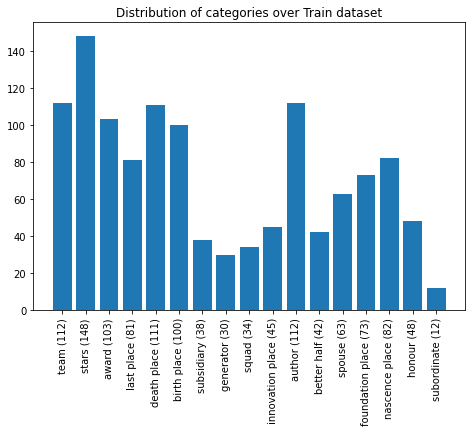

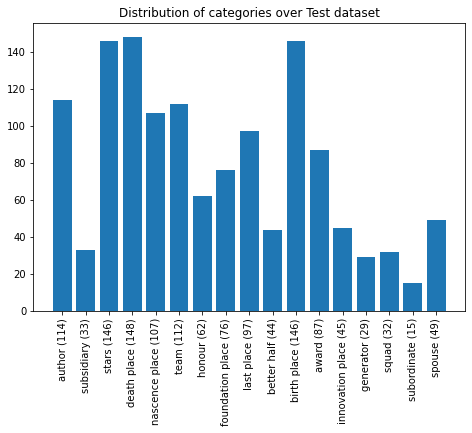

In [23]:
# mount drive and build necessary folders and files
drive.mount('/content/drive')
folder_name = 'SNLP_Fact_Checking-main/SNLP'
directory_folder = f'drive/MyDrive/{folder_name}' 
saved_path = os.path.join(directory_folder, 'saved_path')
train_file = os.path.join(directory_folder, 'SNLP2020_training.tsv')
test_file = os.path.join(directory_folder, 'SNLP2020_test.tsv')

# generate folder to save and load required files
if not os.path.exists(saved_path):
  os.makedirs(saved_path)


# declaration of raw dataset collection
data_collector_train = GatherData(train_file, saved_path, 'train')
categories = data_collector_train.extract_categories()
data_collector_test = GatherData(test_file, saved_path, 'test', categories=categories)

# raw dataset before processing
train_raw_dataset = data_collector_train.save_and_load()
test_raw_dataset = data_collector_test.save_and_load()

# process raw data and gather relevant information
main_categories = categories['bigram_categories'] + categories['unigram_categories']
processor_train = ProcessData(saved_path, 'train_process', data_collector_train)
processor_test = ProcessData(saved_path, 'test_process', data_collector_test)

# processed datasets and extra categories
train_dataset, extra_categories = processor_train.save_and_load(main_categories)
test_dataset, extra_categories = processor_test.save_and_load(main_categories, extra_categories)

# visualization of the dataset
all_categories = main_categories + extra_categories
visualizer = VisualizeData(train_dataset)
ne, textinfo = visualizer.elements_by_categories(all_categories)
visualizer.plot_bars(ne, textinfo, 'Train')

visualizer_test = VisualizeData(test_dataset)
ne_test, textinfo_test = visualizer_test.elements_by_categories(all_categories)
visualizer.plot_bars(ne_test, textinfo_test, 'Test')

# generating links for each information in each data that train and test dataset includes 
resulting_train_file = 'results_train.json'
resulting_test_file = 'results_test.json'
scrapper_train = GetLinks(saved_path, train_dataset, data_collector_train.stop_words)
result_train = scrapper_train.save_and_load(resulting_train_file)
scrapper_test = GetLinks(saved_path, test_dataset, data_collector_test.stop_words)
result_test = scrapper_test.save_and_load(resulting_test_file)

# dictionary of synonyms of the corresponding categories
synonymDB = {
              'nascence place': ['nascence place', 'birth', 'born'],
              'death place': ['death place', 'dead', 'die', 'last place'],
              'stars': ['star', 'starring', 'actor'],
              'team': ["\d{4}"],
              'squad': ["\d{4}"],
              'author': ["author", 'writer', "novelist", 'playwright', 'creator'],
              'foundation place': ['founded', 'foundation', 'base', 'headquarter', 'innnovation place'],
              'award': ['award', 'prize', 'honour', 'decoration', 'reward', 'medal'],
              'last place': ['last place', 'death place', 'dead', 'die'],
              'innovation place': ['innovation place', 'innovation', 'revolution', 'transformation', 'revolution', 'headquarter', 'founded', 'foundation place'],
              'better half': ['better half', 'partner', 'wife', 'husband', 'spouse'], 
              'honour': ['honour', 'distinction', 'tribute', 'award', 'prize', 'decoration', 'reward'], 
              'subsidiary': ['subsidiar', 'successor', 'parent', 'predecessor', 'developer', 'acquire'], 
              'generator': ['generator', 'author'],
              'subordinate': ['subordinate', 'fate', 'acquire', 'acquisition'],
              'spouse': ['spouse', 'partner', 'wife', 'husband', 'better half'],
              'birth place': ['birth place', 'nascence place', 'birth', 'born']  
}


In [24]:
train_all = result_train['all']
test_all = result_test['all']

database = LocalDatabase(saved_path)
train_database = database.generate_database(train_all)
print(len(train_raw_dataset))

1234


In [25]:
# Declaration of web scrapper for test and train datasets, and prediction of train and test labels
testscrape = Scrapping(saved_path, synonymDB, database, 'test')
trainscrape = Scrapping(saved_path, synonymDB, None, 'train')

labelled_train = trainscrape.save_and_load(train_all)
labelled_test = testscrape.save_and_load(test_all, train_database)


In [26]:
# this code cell was implemented as an extra work to compute accuracy of some test data which have already been labelled by using local database (reliable results)
proces_check = tqdm(iterable=enumerate(test_all.items()), desc=f"Checked and labelled: 0 Checked but not labelled: 0", total=len(test_all))
samples = dict()
for idx, (id, value) in proces_check:
  info = value['data']
  info['label'] = database.deep_check(info, train_database)
  
  if info['label'] != 'None':
    samples[id] = value
  else:
    continue
  proces_check.desc = f"Checked and labelled: {database.counter} Checked but not labelled: {database.unbelievable}"
samples = trainscrape.get_pages(samples)


Checked and labelled: 145 Checked but not labelled: 151: 100%|██████████| 1342/1342 [00:01<00:00, 849.76it/s]
General: True: 8/145; ::::: False: 137/145 ::::: Same as original: 137/145; ::::: Accuracy: 0.9448; ::::: M => True BUT O => False: 0/145; ::::: M => False BUT O => True: 8/145: 100%|██████████| 145/145 [02:07<00:00,  1.13it/s]


In [27]:
def generate_output(dataset, filetype):
  name_file = 'result.ttl' if filetype == 'test' else 'result_train.ttl'
  filename = os.path.join(saved_path, name_file)
  if not os.path.exists(filename):
    with open(filename, 'a') as result_file:
      for each_id, each_dict in dataset.items():
        data = each_dict['data']
      # print(f"{each_id} : {data['predicted_label']}")
        result_file.write(f"<http://swc2017.aksw.org/task2/dataset/{each_id}> <http://swc2017.aksw.org/hasTruthValue> {data['predicted_label']}^^<http://www.w3.org/2001/XMLSchema#double> .\n")
    print(f'{name_file} was already generated and saved into {saved_path} folder')
  else:
    print(f'{name_file} is already generated and saved in {saved_path} folder')

generate_output(labelled_test, 'test')
generate_output(labelled_train, 'train')


result.ttl is already generated and saved in drive/MyDrive/SNLP/saved_path folder
result_train.ttl is already generated and saved in drive/MyDrive/SNLP/saved_path folder
